# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [1]:
# Install XGBoost
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release


# import all the usual suspects :)
import os
from google.colab import drive
import pickle
 
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score, accuracy_score
 
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# boosting libraries from XGBoost
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

     |████████████████████████████████| 166.7 MB 22 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
XGBoost version: 1.4.2


# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

## Mount drive with data

In [2]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Mounted at /content/gdrive


## Upload Data and Restrict to Summer/Non-smoky Times

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

Future Weather from Pacific Climate Impacts Consortium
https://services.pacificclimate.org/demo/wx-files/app/

In [3]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-05-23') #*keep last week of May (if available) for lag time
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3 



# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2



# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3


# Future Outdoor Temps
#from https://services.pacificclimate.org/demo/wx-files/app/
df_ftr_avg = pd.read_excel(DATA_PATH + '/Vancouver_Intl_AP_Summary_rcp85.xlsx', sheet_name='Temperature Climatologies') # Averages
df_ftr_25 = pickle.load(open(DATA_PATH +'/processed4clf_2025.pkl','rb')) 
df_ftr_50 = pickle.load(open(DATA_PATH +'/processed4clf_2050.pkl','rb'))
df_ftr_80 = pickle.load(open(DATA_PATH +'/processed4clf_2080.pkl','rb'))

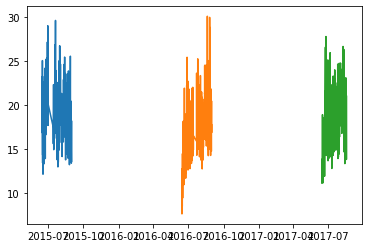

In [4]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# SELECT FEATURES

In [5]:
# keep indoor air temp ONLY
df_2015_X = df_2015_X[['temp','last_temp_2','last_temp_4']]
df_2016_X = df_2016_X[['temp','last_temp_2','last_temp_4']]
df_2017_X = df_2017_X[['temp','last_temp_2','last_temp_4']]

## Add feature for previous temperatures

In [6]:
ls_X = [df_2015_X, df_2016_X, df_2017_X] 

# Add rolling AVERAGE air temp of the PAST 48 hours
def addAverage(df):
    df['temp_ave_48hr'] = df['temp'].rolling(48, min_periods=1).mean() 
    return df 
ls_X2  = [addAverage(df) for df in ls_X]
 

# Add the rolling MAX air temp of the last 24 hours
def addMax(df):
    df['temp_max_24hr'] = df['temp'].rolling(24).max()
    return df 
ls_X3  = [addMax(df) for df in ls_X2]


# Add the rolling MIN air temp of the last 24 hours
def addMin(df):
    df['temp_min_24hr'] = df['temp'].rolling(24).min()
    return df 
ls_X4  = [addMin(df) for df in ls_X3]




ls_X = ls_X4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

## Concatenate 2015, 2016, 2017 into one dataframe

In [7]:
# save a single dataset with all years
df_all_X = pd.concat(ls_X)

## Add feature for time of day 

This step adds a variable to help the model understand the cyclicity of the 24 hours cycle
It borrows from the tutorial provided here: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

We want the machine to know that hours 23 and 0 are closer to each other than hours 0 and 4. We know that the period of the cycle is 24 hours. We can use the cos(x) and sin(x) functions. The x in the functions is the hour of the day.

In [8]:
# Extract the hour of day
df_all_X["hour"] = df_all_X.index.hour

# Transform to the cyclical daily feature 
df_all_X["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]
df_all_X["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]

# Drop hour of the day as it's own feature
df_all_X.drop('hour', axis=1, inplace=True)

## Get outcome variable of interest

## Get indoor air temperatures (for same time spans as outdoor features)

In [9]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times
df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set
df_Y = df_Y[df_Y.index.isin(df_all_X.index)]

# Name column Air Temp Indoors (to distinguish from outdoor or operative indoor)
df_Y = df_Y.to_frame('air_tmp_ind')
df_Y.sort_index(inplace=True)

## Finalize Features and Prediction Target, and Plot some X versus and Y 

In [10]:
# Store the MRT variable as the targetted outcome variable
df_Y_trgt = df_Y[['air_tmp_ind']]
print("predicting: ",df_Y_trgt.columns[0])

# Time stamped features dataframe: df_all_X
print("num of features: ", df_all_X.shape[1])
print("features: ", df_all_X.columns.values)

print("num time points :", df_all_X.shape[0])

predicting:  air_tmp_ind
num of features:  8
features:  ['temp' 'last_temp_2' 'last_temp_4' 'temp_ave_48hr' 'temp_max_24hr'
 'temp_min_24hr' 'day_cos' 'day_sin']
num time points : 4632


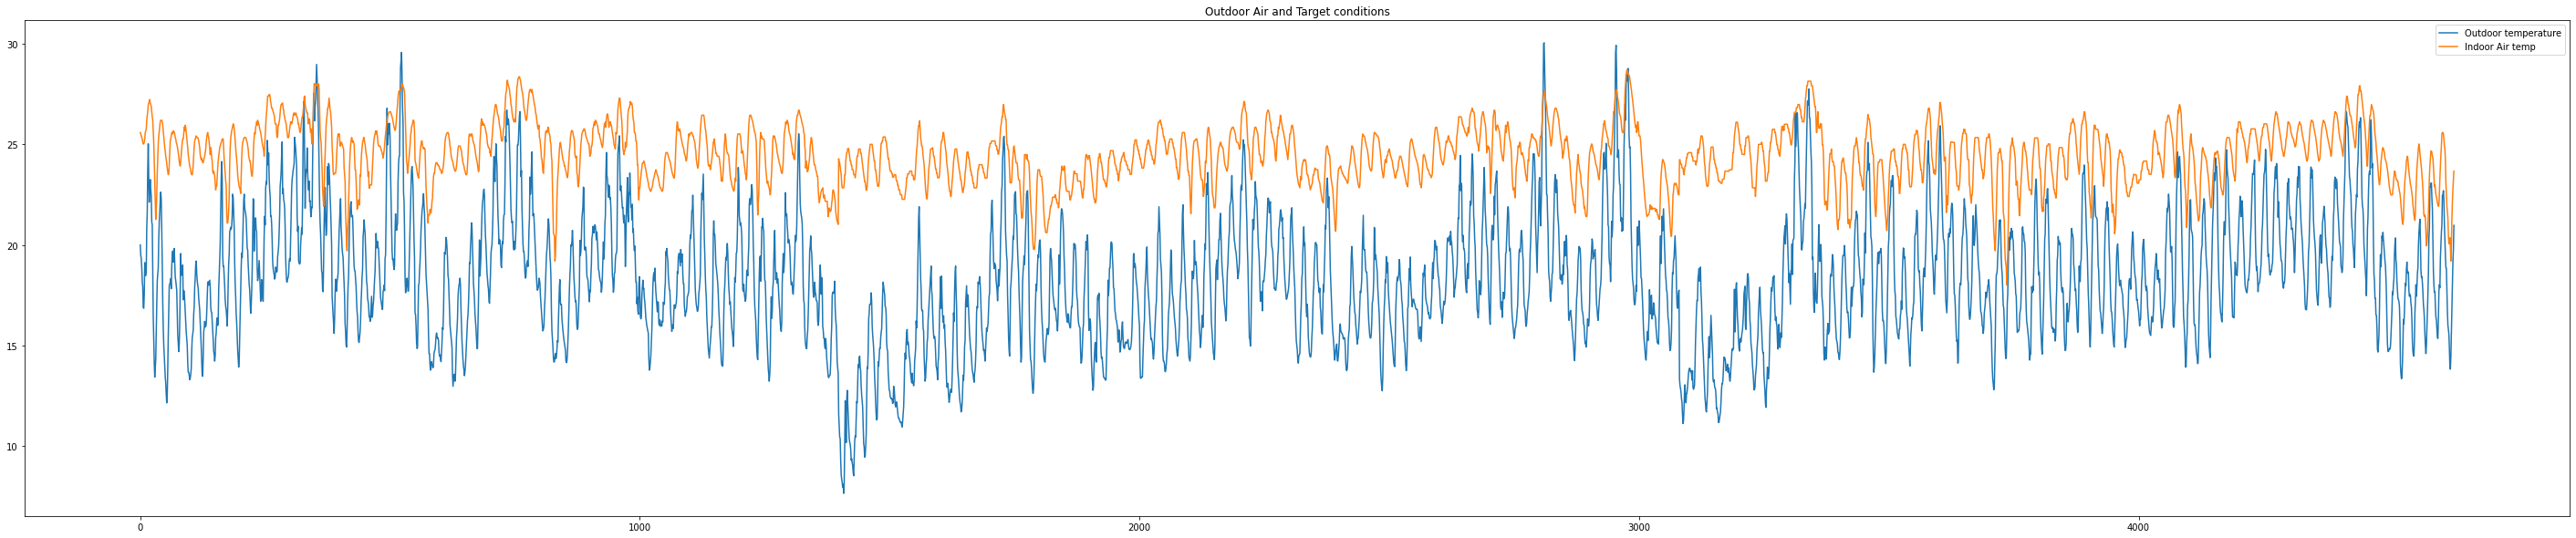

In [11]:
# Visualize the Temperatures (air, comfortable target, required MRT to reach comfortable)
plt.figure(figsize=(50,10))
x_ax = range(len(df_Y_trgt.index))
#plt.plot(x_ax,df_Y_scratch.air_tmp_ind, label="air temperature")
#plt.plot(x_ax, df_Y_scratch.op_tmp_comfy, label="comfortable operative temperature")
plt.plot(x_ax, df_all_X.temp, label="Outdoor temperature")
plt.plot(x_ax, df_Y_trgt.air_tmp_ind, label="Indoor Air temp")

plt.title("Outdoor Air and Target conditions")

plt.legend()
plt.show()

## Extra pre-training step: keep only times of day where you care about adding MRT (i.e., during building operating hours) 

The idea is that we want to optimize the model for predictions during this time of day when we will actually be using the predictions... even if it is worse at night or on average. Recall that in setting up the features, we already recorded the lag variables that contain information about nightime lows and previous hours. These can still inform the prediction of conditions during daytime hours.

In [12]:
# function for filtering out after-hours (keep 8-6? keep weekdays only?)

def remove_unoccupied_times(df_allTimes):

    day = df_allTimes.index.dayofweek # Saturday day_of_week = 5 and Sunday_of_week = 6 
    time = df_allTimes.index.hour
    return df_allTimes.iloc[((day != 5) & (day != 6)) & ((time >= 9) & (time <= 17))]
     

# filter out irrelevant hours from features set X
df_X_occHrs = remove_unoccupied_times(df_all_X.copy())
 
#filter out irrelevant hours from target y
df_y_occHrs = remove_unoccupied_times(df_Y_trgt.copy())

In [32]:
df_y_occHrs

,air_tmp_ind
2015-06-15 09:00:00,25.27
2015-06-15 10:00:00,25.59
2015-06-15 11:00:00,25.69
2015-06-15 12:00:00,25.77
2015-06-15 13:00:00,26.20
...,...
2017-08-18 10:00:00,21.27
2017-08-18 11:00:00,22.17
2017-08-18 12:00:00,22.74
2017-08-18 13:00:00,23.17


## Save training/test data to pickle

In [33]:
# Save features to pickle
pickle.dump(df_X_occHrs, open(DATA_PATH + '/X_occHrs.p', 'wb'))

# Save output target variable to pickle
pickle.dump(df_y_occHrs, open(DATA_PATH + '/y_occHrs.p', 'wb'))

# DEFINE and RUN XGBoost MODELS 

## Split training and test sets, and save date-time stamps as separate array

In [13]:
x = df_X_occHrs.copy().to_numpy()

# need to reshape Y which contains 1 features (currently it's 0) 
y = df_y_occHrs.copy().to_numpy().reshape(-1,1)

# create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)
t = df_X_occHrs.index.copy()

# NB split should not be an unordered... (shuffle=False)
x_train, testX, y_train, testY, time_train, testTime = train_test_split(x, y, t, shuffle = False, test_size= 0.15)

# check
print("time stamps for train and test sets:", time_train.shape, testTime.shape)
print("train_dim Xs and Y:", x_train.shape, y_train.shape)
print("test_dim Xs and Y", testX.shape, testY.shape)

time stamps for train and test sets: (1060,) (188,)
train_dim Xs and Y: (1060, 8) (1060, 1)
test_dim Xs and Y (188, 8) (188, 1)


## Define the XGBoost objective function and search hyper-parameter space

### Set up parameters (with aim of using HyperOpt to optimize)

 

In [14]:
# Borrowed instructions from here: https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9
# Training data: x_train and y_train 
# Testing data: testX and testY 

# Initialize fixed values (won't be tuned)
N_EST = 1000 
ETA = 0.05  # learning rate range : [0,1] Typical final values : 0.01-0.2
SUB = 0.85 # Typical values: 0.5-1 ... Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
 
# Initialize required range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1), #L2 regularization term on weights (analogous to Ridge regression)
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        
    }
    
# Define regression objective function: 
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = N_EST, 
                           eta =  ETA,
                           subsample = SUB,
                           max_depth = int(space['max_depth']), 
                           gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']),
                           reg_lambda = space['reg_lambda'],
                           colsample_bytree=space['colsample_bytree'],
                           min_child_weight=space['min_child_weight'],
                           verbose=0)
    
    evaluation = [( x_train, y_train), ( testX, testY)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse", # objective [default=reg:squarederror]
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(testX)
    mse= mean_squared_error(testY, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

In [15]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            verbose=0)

[21:27:28] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


SCORE:
0.892899071041939
[21:27:28] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


SCORE:
0.6809761972259853
[21:27:28] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please ope

In [16]:
best

{'colsample_bytree': 0.9944971025292292,
 'gamma': 1.10761591310306,
 'max_depth': 9.0,
 'min_child_weight': 4.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.989837623232645}

## Fit the tuned model with the training data

Re-train the model algorithm using the best parameters obtained using hyperopt and evaluate it's predictions against the test set 

In [17]:
# create an xgboost regression model with the best hyperparameters (based on tuning above)
model = xgb.XGBRegressor(n_estimators = N_EST, 
                           eta =  ETA,
                           subsample = SUB,
                           max_depth = int(best['max_depth']), 
                           gamma = best['gamma'],
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           colsample_bytree= best['colsample_bytree'],
                           min_child_weight= best['min_child_weight'])
    
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9944971025292292, eta=0.05,
             gamma=1.10761591310306, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0500000007,
             max_delta_step=0, max_depth=9, min_child_weight=4.0, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=2,
             num_parallel_tree=1, random_state=0, reg_alpha=41,
             reg_lambda=0.989837623232645, scale_pos_weight=1, subsample=0.85,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Use Model to Predict values (and compare to test set)

## MSE and Visually examine predicted indoor air temp against test set 

MSE: 0.51
RMSE: 0.71


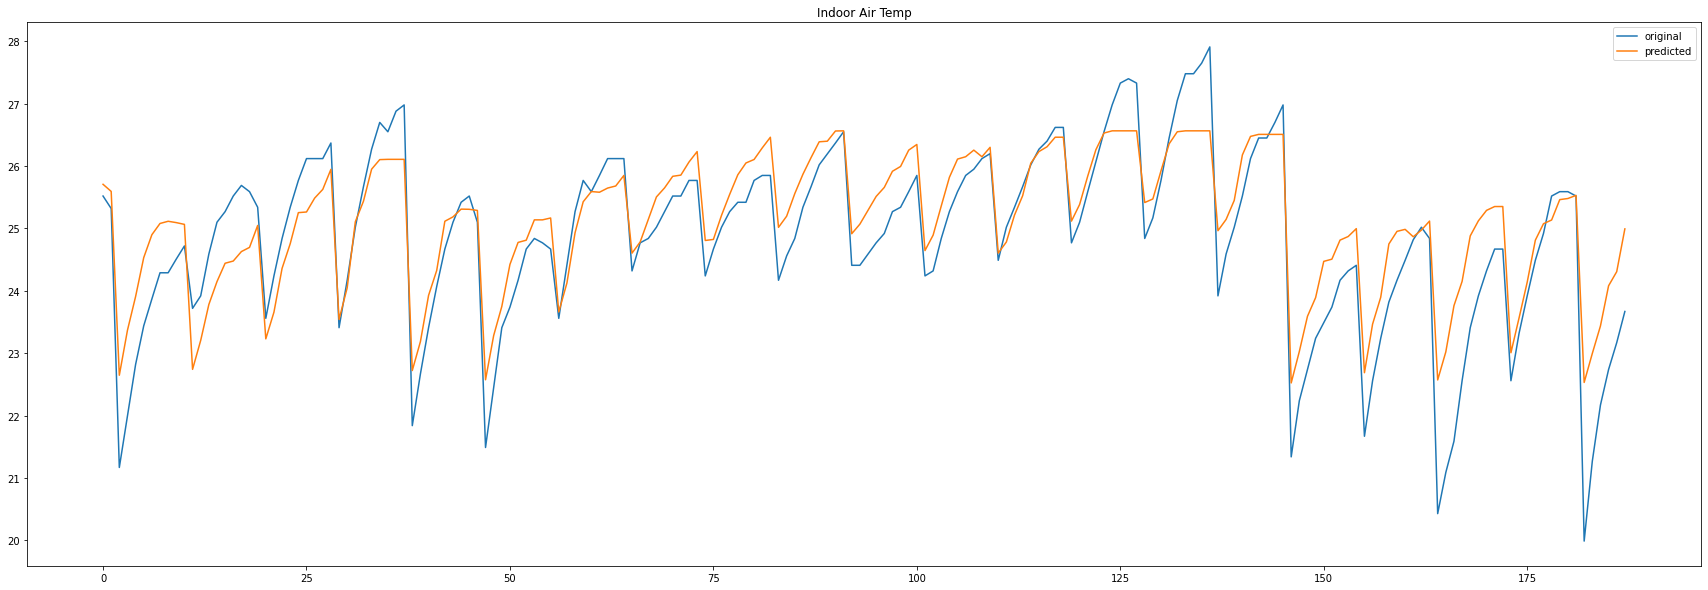

In [18]:
# Prediction
y_pred = model.predict(testX)

# Calculate Mean Squared Error
mse = mean_squared_error(testY, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# Visualize Predictions versus Test Set
plt.figure(figsize=(30,10))
x_ax = range(len(testY))
plt.plot(x_ax, testY, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Indoor Air Temp")

plt.legend()
plt.show()

#  USE PREDICTION (OR KNOWN INDOOR TEMP) ALONG WITH OUTDOOR TEMP TO CALCULATE DESIRED LOCAL MRT

###  Finding the (hourly) 'comfortable' operative temperature based on average outdoor air temperatures  

The adaptive comfort model's stipulated 'comfortable oeprative temperature' which is defined as a function of the average outdoor air temperature.

Tcomf = 0.31*[Ta,out] + 17.8

where: Tcomf = indoor comfortable temperature
Ta,out = mean outdoor air temperature*

*mean outdoor temperature as the input variable for the adaptive model. It is based on the arithmetic average of the mean daily outdoor temperatures over no fewer than 7 and no more than 30 sequential days prior. We will use 7.


sources:
ANSI/ASHRAE Standard 55-2017, Thermal Environmental Conditions for Human Occupancy. de Dear, R., & Brager, G. S. (2002). Thermal comfort in naturally ventilated buildings: revisions to ASHRAE Standard 55. Energy and Buildings, 34, 549-561.

In [19]:
def get_comfy_opTemperature (outdoor_air):

    # Calculate average of previous week's outdoor air temp (for calculating comfortable op temp)
    out_7dayAverage = outdoor_air.rolling(168, min_periods=72).mean() 

    # Calculate adaptive model comfort temp
    return 0.31*out_7dayAverage +17.8

### Use comfy threshold to find the (hourly) local MRT necessary given background indoor temps

The desired 'outcome' is whether the current hour is 'comfortable', based on comparing the indoor air temperature and the adaptive comfort model's stipulated 'comfortable oeprative temperature' (see previous block). 

GAP = op_temp_comfy - op_temp

where

op_temp = 0.5*(air_temp + MRT)

i.e., indoor operative temperature is an average of air temperature and mean radiant temperature, MRT

If the GAP is 0, then:

op_temp_comfy == op_temp

op_temp_comfy == 0.5*(air_temp + MRT)

And re-written to find what the gap is in terms of MRT:

MRT = 2*op_temp_comfy - air_temp

In [20]:
def get_required_MRT(comfy_operativeTemp,indoor_airTemp): 
    # this is the gap between indoor AIR temp and desired indoor OPERATIVE temp
    return 2*comfy_operativeTemp - indoor_airTemp

## Using above functions, calculate the MRT 
1. using each of the whole data, and then 
2. for the time period of just test set (i.e., known vs. prediction-based indoor temp)

### 1. MRT based on the entire input set (ie. known outdoor and known indoor)

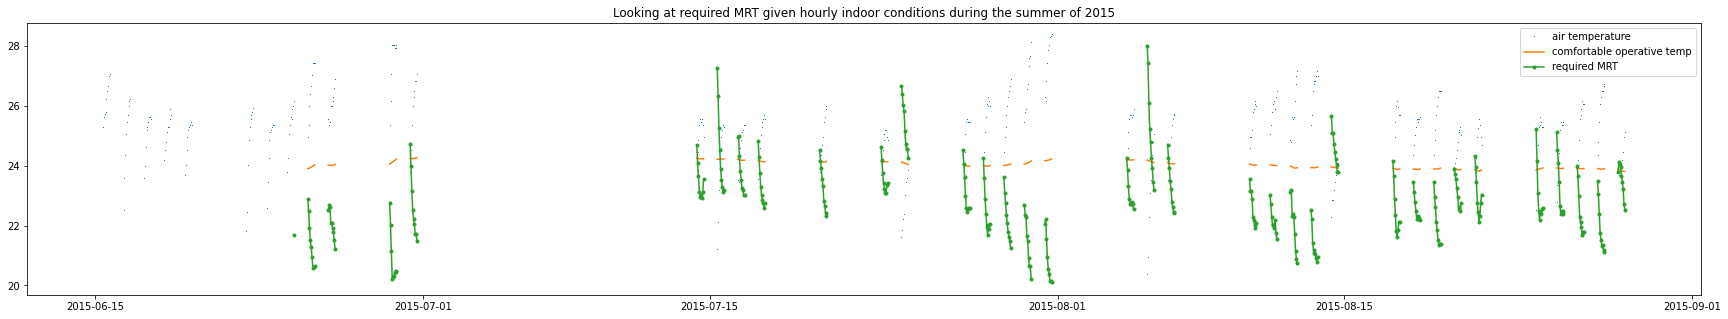

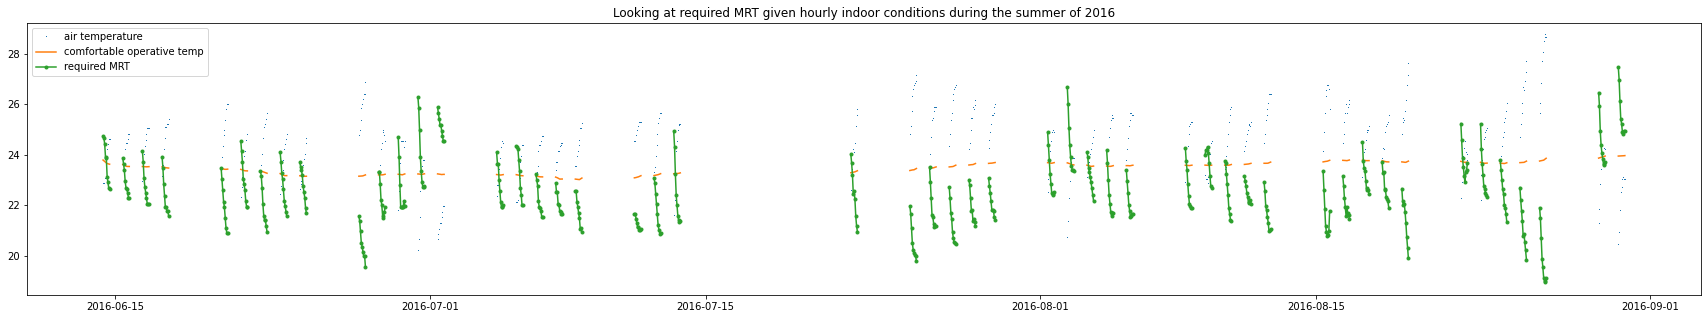

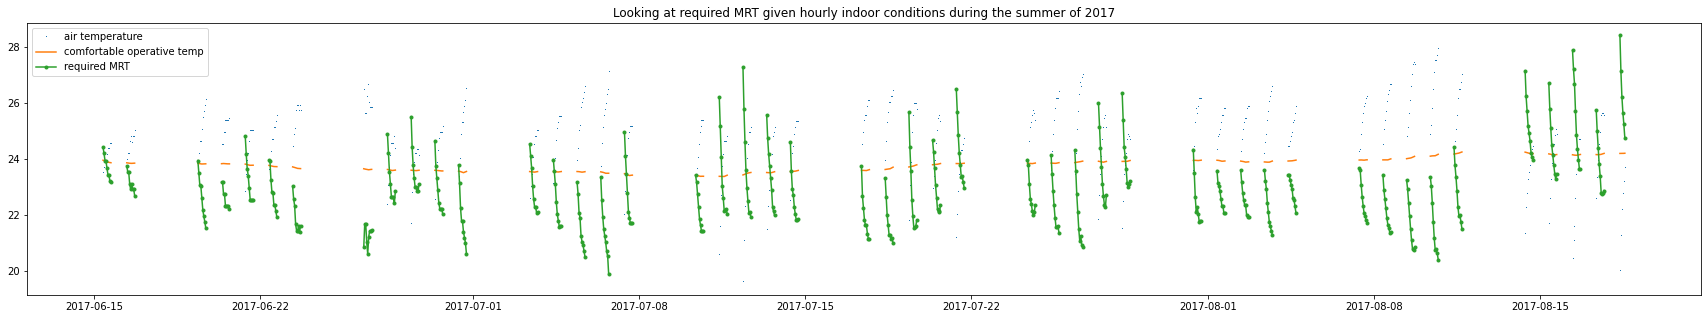

In [21]:
# We don't need all the features from the X set, just the outdoor temp! 
out_air = pd.Series(x[:,0]) # # x_train[:,0] or testX[:,0] are the split of df_all_X['temp'] 

# Get the target variable (indoor temp) either 'real' or predicted
ind_air = pd.Series(y[:,0]) # change y to test_Y or y_pred 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT = get_required_MRT(comfy_opTmp,ind_air)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_ = pd.DataFrame({'ind_air': ind_air, 
                   'out_air':out_air,
                   'comfy_opTmp': comfy_opTmp,
                   'comfy_MRT': comfy_MRT}).set_index(t) #recall t was the original date-time stamp df_all_X.index 

# Try adding don't want to plot as rows of NANs explicitly... to allow matplotlib to "mask" these instead of connecting
# Merge this dataframe that only has data for days/times during occupied hours, with the longer data-time index from  a longer df that has "all" the dates
df_all = df_Y_trgt.join(df_).drop('air_tmp_ind',1) # This fills in missing rows explicitly with NaNs
 

def visualize_given_year(dat=df_all.copy(), year=2015):
    yr = year

    df_plot = dat.copy()

    # keep only summer dates, e.g., June, July and August:
    df_yr = df_plot[df_plot.index.month.isin([6,7,8]) & (df_plot.index.year == yr)]

    # Plot it
    plt.figure(figsize=(30,5))
    
    x_ax = df_yr.index
    plt.plot(x_ax, df_yr.ind_air, label="air temperature", linestyle='', marker=',')
    plt.plot(x_ax, df_yr.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
    plt.plot(x_ax, df_yr.comfy_MRT, label="required MRT", linestyle='-', marker='.')
    plt.title("Looking at required MRT given hourly indoor conditions during the summer of %i" %yr)
    plt.legend()
    plt.show()

# Visualize 2015
visualize_given_year(df_all, 2015)

# Visualize 2016
visualize_given_year(df_all, 2016)

# Visualize 2017
visualize_given_year(df_all, 2017)

### 2. MRT based on test set (ie. compared known to predicted indoor)

In [22]:
# Set the outdoor air, restrict to test set this time
out_air = pd.Series(testX[:,0]) # we just need column with outdoor temp! 

# First change the size of the array of prediciton to match the array of the test
y_pred = y_pred.reshape(-1,1)

# Get the target variable (indoor temp) either 'real' or predicted
ind_air_known = pd.Series(testY[:,0]) # test set of real indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_known = get_required_MRT(comfy_opTmp,ind_air_known)
comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_all_2 = pd.DataFrame({'ind_air': ind_air_known, 
                       'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_known,
                        'comfy_MRT_pred': comfy_MRT_pred}).set_index(testTime) #recall t was the original date-time stamp df_all_X.index 

                        

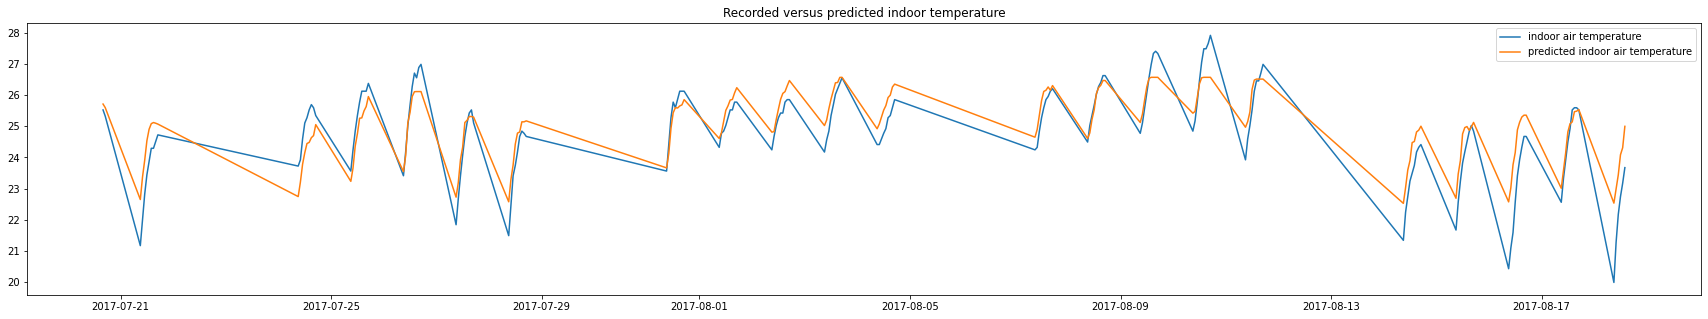

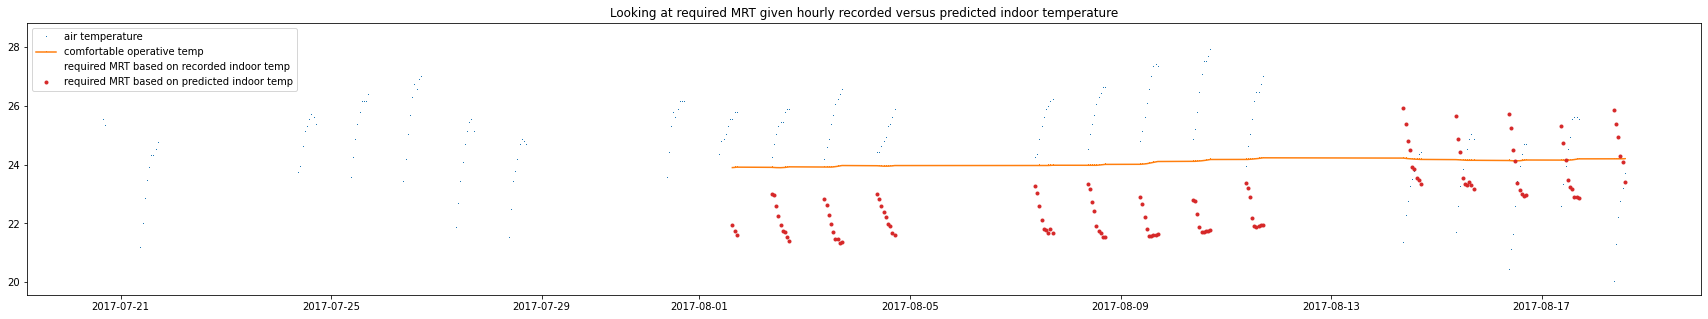

In [23]:
df_plot = df_all_2.copy()

plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="indoor air temperature", linestyle='-', marker='')
plt.plot(x_ax, df_plot.ind_air_predicted, label="predicted indoor air temperature", linestyle='-', marker='')
plt.title("Recorded versus predicted indoor temperature")
plt.legend()
plt.show()


plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="air temperature", linestyle=' ', marker=',')
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker=',')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show()

## How did the prediction-based MRT perform relative to the known-temp-based MRT? Specifically, we care about the performance during occupied hours... (and peaks along with dewpoint, more than hour-by-hour accuracy).

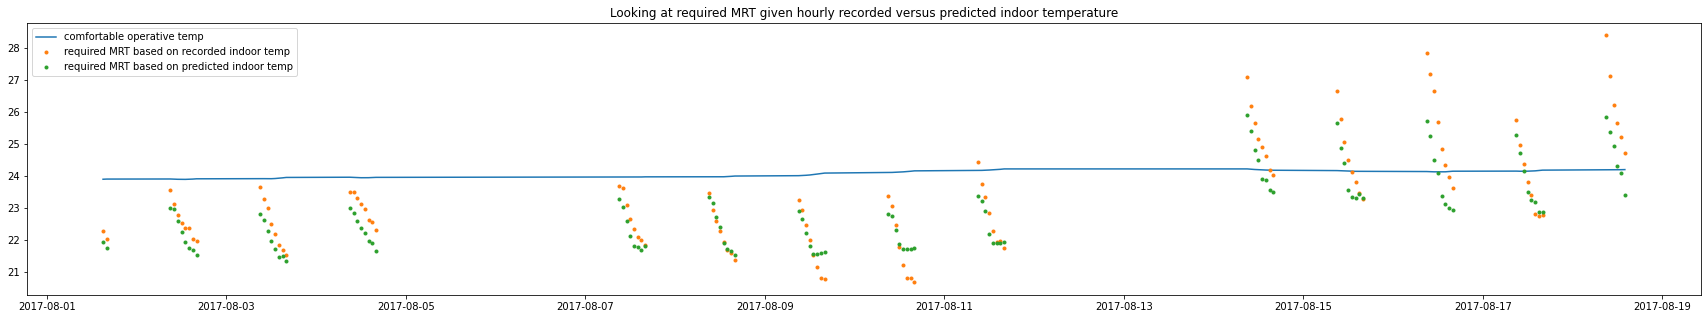

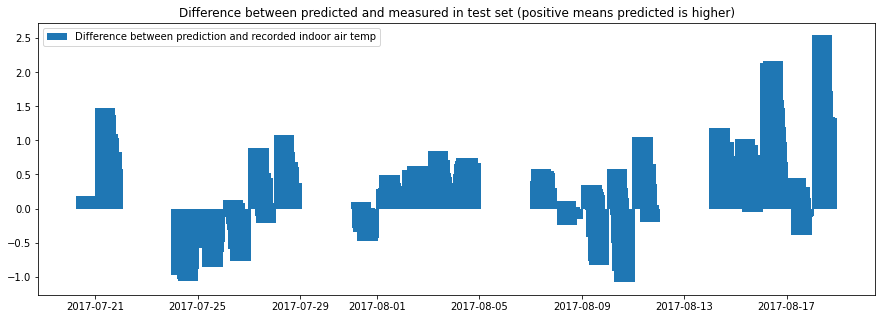

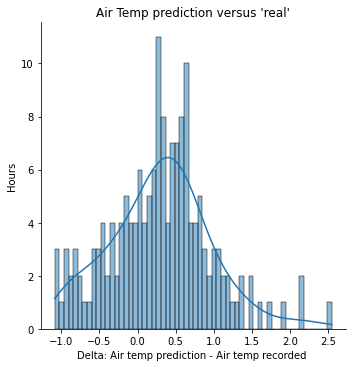

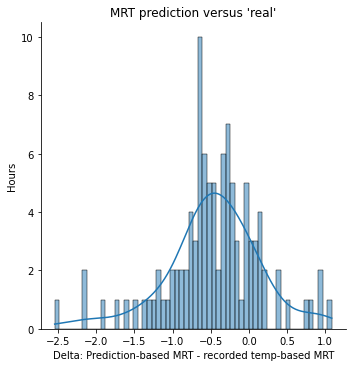

In [24]:
# Compare times of day when occupied to see 'how good' the prediction is...
df_daytime = df_all_2[df_all_2.index.hour.isin(range(9,17))] # Filter by time of day on df_all_2 which holds the results of text x, test y and predicted Y, along with MRT. 

#Visualize occupied hours only
df_plot=df_daytime.copy()
x_ax = df_plot.index

plt.figure(figsize=(30,5))
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='.')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show() # looks like our model is biased to underestimate needed MRT... 

# alternative to above plot.. #graphically white-out spans of unoccupied times? 
# see fill bewteen two vertical lines https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
# ax.axvspan(8, 14, alpha=0.5, color='red')

# For another look: directly plot the difference between MRT based on prediction and recorded  
df_plot['diff_air'] = df_plot['ind_air_predicted'] - df_plot['ind_air']
df_plot['diff_MRT'] = df_plot['comfy_MRT_pred'] - df_plot['comfy_MRT']

model1_sum_of_diff_MRT = df_plot['diff_MRT'].abs().sum()
model1_mean_diff_MRT = df_plot['diff_MRT'].mean()

plt.figure(figsize=(15,5))
plt.bar(x_ax, df_plot.diff_air, label="Difference between prediction and recorded indoor air temp")
#plt.bar(x_ax, df_plot.diff_MRT, label="Resulting difference between prediction-based and record-based MRT to stay comfortable")
plt.title("Difference between predicted and measured in test set (positive means predicted is higher)")
plt.legend()
plt.show() 
 
p1 = sns.displot(df_plot.diff_air, bins=60, kde=True)
p1.set( xlabel = "Delta: Air temp prediction - Air temp recorded ", ylabel = "Hours", title="Air Temp prediction versus 'real'")

p2 = sns.displot(df_plot.diff_MRT, bins=60, kde=True)
p2.set( xlabel = "Delta: Prediction-based MRT - recorded temp-based MRT", ylabel = "Hours", title="MRT prediction versus 'real'")


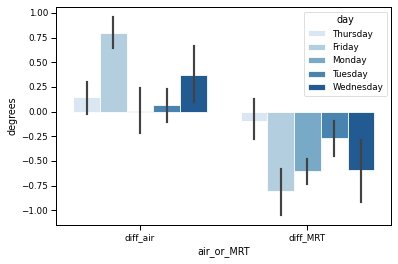

In [25]:
# looks like our model is biased to underestimate temp and thus overestimate cooling needed 

# If we group by day of the week, does the amount of cooling undershoot or overshoot and by how much? 

sns.set_context('paper')
df_long = df_plot[['diff_air','diff_MRT']].reset_index().melt(id_vars='index', var_name='air_or_MRT', value_name='degrees').rename(columns={'index':'time_stamp'})
df_long['day'] = df_long['time_stamp'].dt.day_name()

sns.barplot(x = 'air_or_MRT', y = 'degrees',  data = df_long,
            hue ='day',
            palette = 'Blues', edgecolor = 'w')
df_long.groupby(['day','air_or_MRT']).mean()
plt.show()

# TRY A SHUFFLED SPLIT of TRAINING/TEST SET:
Does it do better if we randomly subset our test and prediction data points? Will no longer correspond to one continuous time... but, may do better at generalizing... 

[21:27:52] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


SCORE:
0.5978410976175315
[21:27:52] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


SCORE:
0.9525637968560022
[21:27:53] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

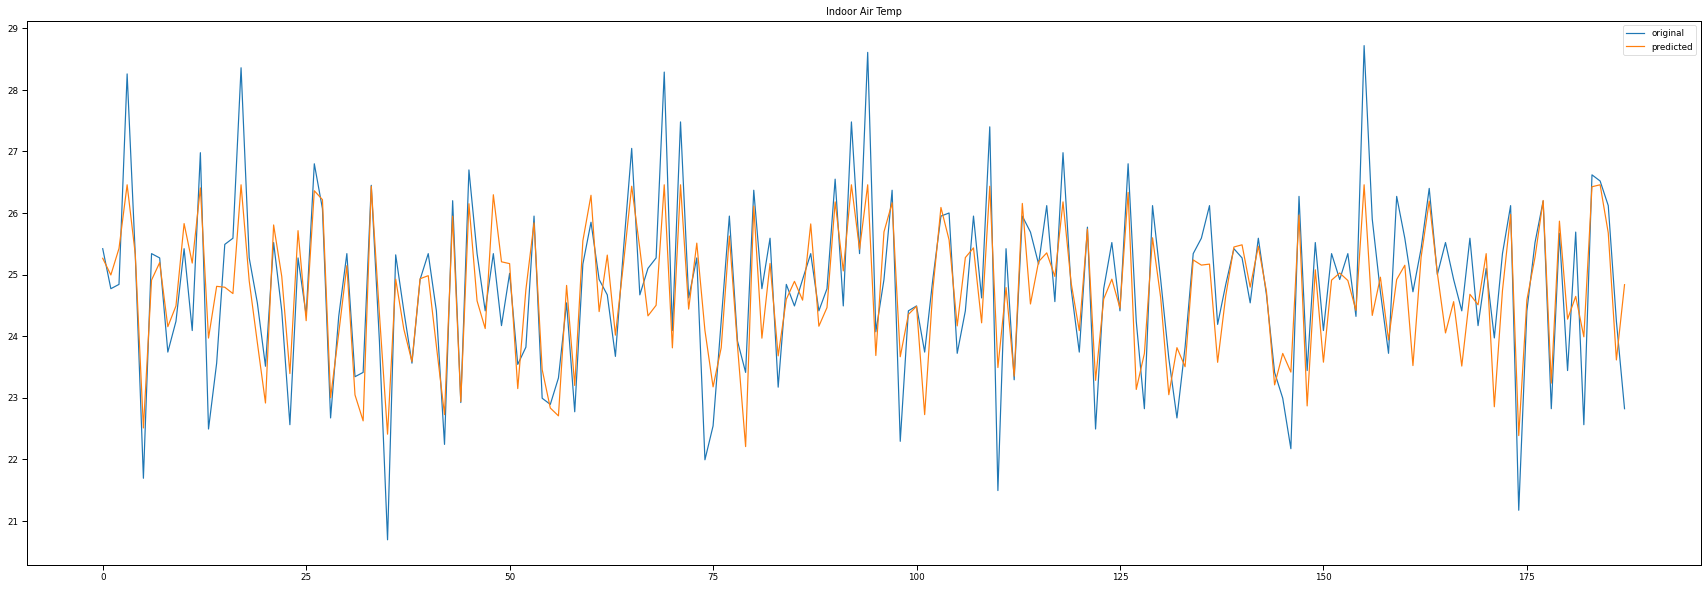

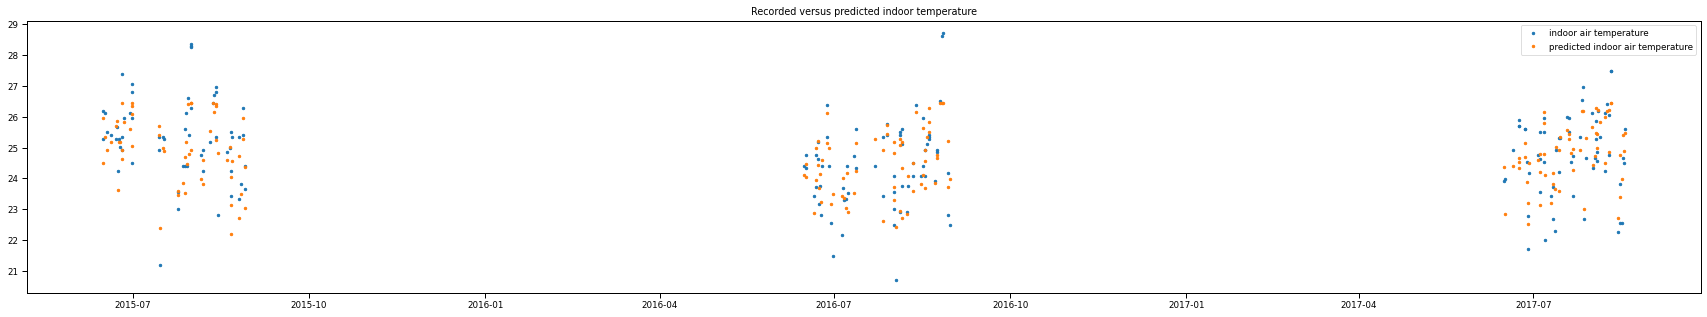

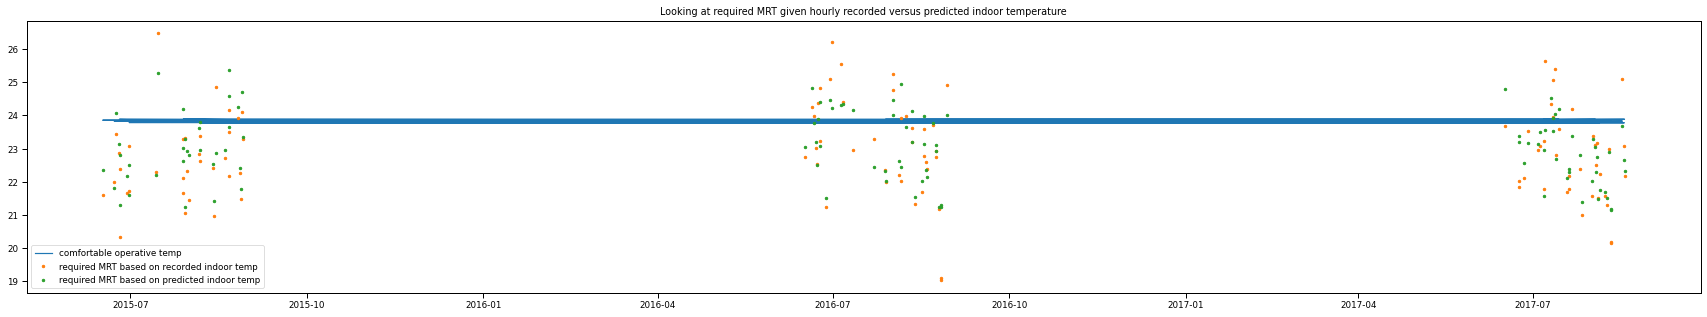

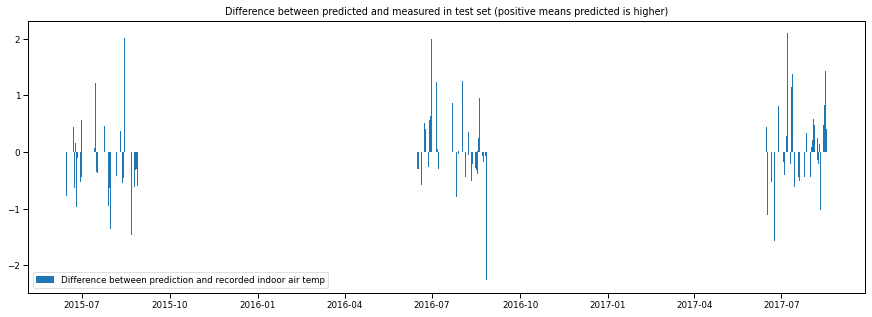

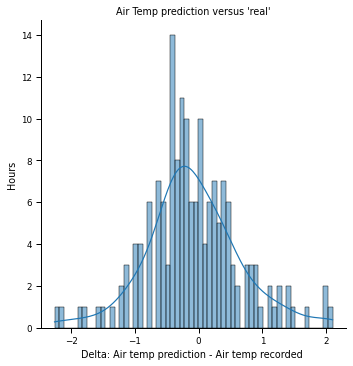

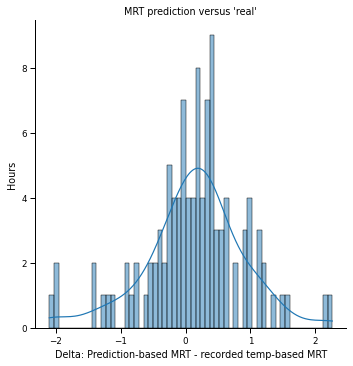

In [26]:
# Re-run the model tuning and training but with a different split of training/test data

# Split training and test sets, and save date-time stamps as separate array
x = df_X_occHrs.copy().to_numpy()

# need to reshape Y which contains 1 features (currently it's 0) 
y = df_y_occHrs.copy().to_numpy().reshape(-1,1)

# create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)
t = df_X_occHrs.index.copy()

# NB split will be UNORDERED this time!!  (i.e., shuffle=True)
x_train, testX, y_train, testY, time_train, testTime = train_test_split(x, y, t, shuffle = True, test_size= 0.15)

# Reuse the Set up parameters and the HyperOpt function defined above
trials_shuffled = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_shuffled,
            verbose=0)

#Re-train the model algorithm using the 'best' parameters and evaluate it's predictions against the test set
model2 = xgb.XGBRegressor(n_estimators = N_EST, 
                           eta =  ETA,
                           subsample = SUB,
                           max_depth = int(best['max_depth']), 
                           gamma = best['gamma'],
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           colsample_bytree= best['colsample_bytree'],
                           min_child_weight= best['min_child_weight'])
    
model2.fit(x_train, y_train, verbose = 0)

# Prediction
y_pred = model2.predict(testX)

# Calculate Mean Squared Error
mse2 = mean_squared_error(testY, y_pred)
print("MSE: %.2f" % mse2)
print("RMSE: %.2f" % (mse2**(1/2.0)))

# Visualize Predictions versus Test Set
plt.figure(figsize=(30,10))
x_ax = range(len(testY))
plt.plot(x_ax, testY, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Indoor Air Temp")
plt.legend()
plt.show()

# Calculate MRT to achieve comfortable operating temp

# Set the outdoor air, restrict to test set this time
out_air = pd.Series(testX[:,0]) # we just need column with outdoor temp! 

# First change the size of the array of prediciton to match the array of the test
y_pred = y_pred.reshape(-1,1)

# Get the target variable (indoor temp) either 'real' or predicted
ind_air_known = pd.Series(testY[:,0]) # test set of real indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_known = get_required_MRT(comfy_opTmp,ind_air_known)
comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_all_2 = pd.DataFrame({'ind_air': ind_air_known, 
                       'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_known,
                        'comfy_MRT_pred': comfy_MRT_pred}).set_index(testTime) #recall t was the original date-time stamp df_all_X.index 

# PLOTS
df_plot = df_all_2.copy()

plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="indoor air temperature", linestyle='', marker='.')
plt.plot(x_ax, df_plot.ind_air_predicted, label="predicted indoor air temperature", linestyle='', marker='.')
plt.title("Recorded versus predicted indoor temperature")
plt.legend()
plt.show()

# Compare times of day when occupied to see 'how good' the prediction is...
df_daytime = df_all_2[df_all_2.index.hour.isin(range(9,17))] # Filter by time of day on df_all_2 which holds the results of text x, test y and predicted Y, along with MRT. 

#Visualize occupied hours only
df_plot=df_daytime.copy()
x_ax = df_plot.index

plt.figure(figsize=(30,5))
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='.')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show() #


# For another look: directly plot the difference between MRT based on prediction and recorded  
df_plot['diff_air'] = df_plot['ind_air_predicted'] - df_plot['ind_air']
df_plot['diff_MRT'] = df_plot['comfy_MRT_pred'] - df_plot['comfy_MRT']

model2_sum_of_diff_MRT = df_plot['diff_MRT'].abs().sum()
model2_mean_diff_MRT = df_plot['diff_MRT'].mean()

plt.figure(figsize=(15,5))
plt.bar(x_ax, df_plot.diff_air, label="Difference between prediction and recorded indoor air temp")
#plt.bar(x_ax, df_plot.diff_MRT, label="Resulting difference between prediction-based and record-based MRT to stay comfortable")
plt.title("Difference between predicted and measured in test set (positive means predicted is higher)")
plt.legend()
plt.show() 
 
p1 = sns.displot(df_plot.diff_air, bins=60, kde=True)
p1.set( xlabel = "Delta: Air temp prediction - Air temp recorded ", ylabel = "Hours", title="Air Temp prediction versus 'real'")

p2 = sns.displot(df_plot.diff_MRT, bins=60, kde=True)
p2.set( xlabel = "Delta: Prediction-based MRT - recorded temp-based MRT", ylabel = "Hours", title="MRT prediction versus 'real'")

## COMPARE MODELS
 


In [27]:
# Model 1 (unshuffled test set)
print("MODEL 1: Unshuffled Test Set")
print("MSE of indoor air prediction: %.2f" % mse2)
print("RMSE: %.2f" % (mse2**(1/2.0)))
print ("...Restricting to occupational hours")
print("Sum Absolute Degree-Hours Delta between prediciton and test %.2f" % model1_sum_of_diff_MRT)
print("Average Degree-Hours Delta between prediciton and test %.2f" % model1_mean_diff_MRT)
print("\n") 

# Model 2 
print("MODEL 2: Shuffled Test Set")
print("MSE of indoor air prediction: %.2f" % mse2)
print("RMSE: %.2f" % (mse2**(1/2.0)))
print ("... Now Restricting to occupational hours")
print("Sum Absolute Degree-Hours Delta between prediciton and test %.2f" % model2_sum_of_diff_MRT)
print("Average Degree-Hours Delta between prediciton and test %.2f" % model2_mean_diff_MRT)

# Prefer second model because error is centered around zero...meaning lower bias toward over-or-under-estimating

MODEL 1: Unshuffled Test Set
MSE of indoor air prediction: 0.54
RMSE: 0.73
...Restricting to occupational hours
Sum Absolute Degree-Hours Delta between prediciton and test 62.93
Average Degree-Hours Delta between prediciton and test -0.47


MODEL 2: Shuffled Test Set
MSE of indoor air prediction: 0.54
RMSE: 0.73
... Now Restricting to occupational hours
Sum Absolute Degree-Hours Delta between prediciton and test 61.56
Average Degree-Hours Delta between prediciton and test 0.13


# FUTURE PROJECTIONS

### Load data into dataframes and create features to match training set

Should match the columns of training set: e.g., df_X_occHrs

features:  ['temp' 'last_temp_2' 'last_temp_4' 'temp_ave_48hr'
 'temp_max_24hr' 'temp_min_24hr' 'day_cos' 'day_sin']

In [28]:
df_ftr_80[['temp']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36461 entries, 2013-08-22 00:00:00 to 2080-09-30 23:00:00.003000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    36461 non-null  float64
dtypes: float64(1)
memory usage: 569.7 KB


In [29]:
# For each future year, take outdoor temp and get related 'features'
ls_ftr_Xraw = [df_ftr_25[['temp']], df_ftr_50[['temp']], df_ftr_80[['temp']]] 

 
# Add Features 
def addPreviousTemperatures(df):
    #add features one at a time
    df['last_temp_2'] = df.temp.shift(2)
    df['last_temp_4'] = df.temp.shift(4)
    df['temp_ave_48hr'] = df.temp.rolling(48, min_periods=1).mean()
    df['temp_max_24hr'] = df.temp.rolling(24).max()
    df['temp_min_24hr'] = df.temp.rolling(24).min()

    # for sin and cos feature, need the hour of day
    df['hour'] = df.index.hour
    # Transform to the cyclical daily feature 
    df['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in df['hour']]
    df["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df['hour']]
    # Drop hour of the day as it's own feature
    df.drop('hour', axis=1, inplace=True)

    return df 

ls_ftr_X  = [addPreviousTemperatures(df.copy()) for df in ls_ftr_Xraw]

# filter out irrelevant hours from features set X
ls_ftr_X_occHrs  = [remove_unoccupied_times(df) for df in ls_ftr_X]

# keep only summer dates, e.g., June, July and August:
ls_ftr_X_summrHrs = [df.query('index.dt.month in [6,7,8]') for df in ls_ftr_X]


# save a single dataset with all years
ftr_X_summrHrs = pd.concat(ls_ftr_X_summrHrs) 

## Predictions for 2023 to 2080

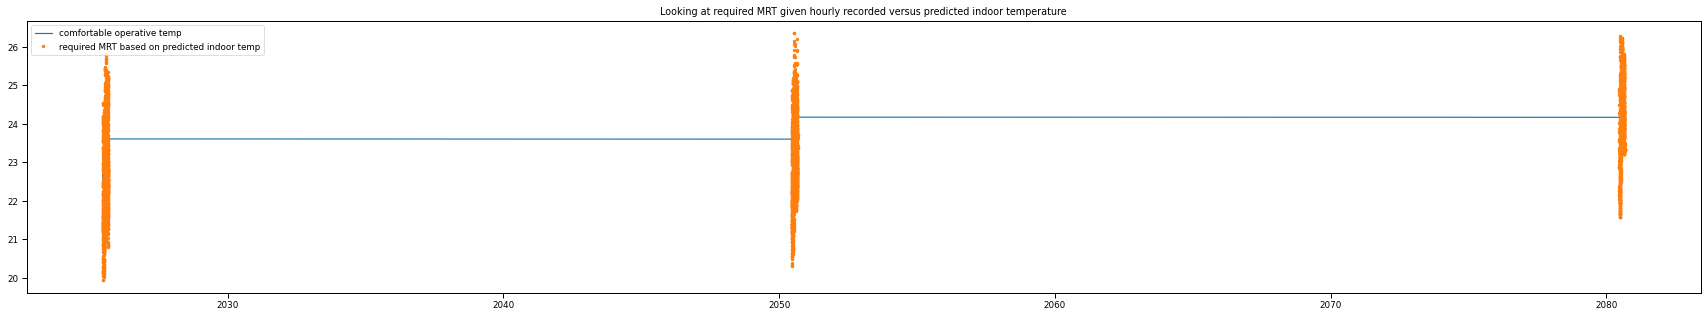

In [30]:
# 2023- 2080
# work with data set that goes to 2080
X_to_2080 = ftr_X_summrHrs.copy()

# Cut years before 2023
remove_before = pd.to_datetime('2023-06-01') #*keep last week of May (if available) for lag time
X_2023_80 = X_to_2080.query('index >= @remove_before')


x = X_2023_80.to_numpy()
t = X_2023_80.index.copy() # create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)

# Extra step to reformat in a way that doesn't throw an error inside the model's prediction function
x_all, testX, time_all, testTime = train_test_split(x, t, shuffle = False, test_size= 0.0001)

# Prediction 2025
pred_2025 = model2.predict(x_all)

# Calculate MRT to achieve comfortable operating temp

# Set the outdoor air 
out_air = pd.Series(x_all[:,0])  

# First change the size of the array of prediciton to match the array of the test
y_pred = pred_2025.reshape(-1,1)

# Get predicted indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp, Comfortable Target Operative Temp, Required MRT 
df_all_ftr = pd.DataFrame({'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_pred}).set_index(time_all) #recall t was the original date-time stamp df_all_X.index 

# PLOTS
df_plot = df_all_ftr.copy()
x_ax = df_plot.index

# Visualize Each of 2025, 2050 and 2080 on subplots:
plt.figure(figsize=(30,5))
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show() 

## TO DO:



*   Quantify degree-hours that exceed comfort threshold during the summer, during occupied building hours, without any intervention. For each year (e.g., in recorded years, and in future years). 
*    Quantify what background MRT 'needs to be' (i.e., our model calc) to keep things comfortable... furthermore, how often (and when) this drops below the estimated dew point (in recorded years and in future years).
*   More detailed analysis: if we have scenarios where panels account for X% of view factor (and 'background MRT' is 1-X%), then what does the panel MRT need to be? AND how often (and when) does the MEMBRANE drop below the estimated dew point? 
*    AND how much energy would it take to keep occupants comfy PER OCCUPANT and TOTAL? (how 

* Ultimately, metric to calculate: % of comfortable hours as a function of view factor, year, climate change 
* Could we estimate the error of this 'end-to-end' prediction? Where is the error largest? (e.g., model of outdoor-indoor, weather inputs of future climate versus comfort model versus inherennt VF?) 

 check wheather we really want weather: https://www.weathershift.com/purchase/
 https://services.pacificclimate.org/wx-files/app/

 check adaptive method model at https://comfort.cbe.berkeley.edu








Approximation of actual background MRT (as different from desired background to maintain comfortable conditions)#

Notes
 approximation of dew point temperature if you know the observed temperature and relative humidity

Td = T - ((100 - RH)/5.)

where Td is dew point temperature (in degrees Celsius), T is observed temperature (in degrees Celsius), and RH is relative humidity (in percent). Apparently this relationship is fairly accurate for relative humidity values above 50%.

More details can be found in the article:

Lawrence, Mark G., 2005: The relationship between relative humidity and the dewpoint temperature in moist air: A simple conversion and applications. Bull. Amer. Meteor. Soc., 86, 225-233. doi: http;//dx.doi.org/10.1175/BAMS-86-2-225


Next steps#
Run with future outdoor air temps on same building.
Run with this summer's air temps? 

In parallel: how to quantify and best communicate level of 'error' and level of 'uncertainty' 